In [1]:
# Import packages
import pandas as pd
from karateclub import Diff2Vec
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import faiss
import seaborn as sns
from tqdm import tqdm

In [20]:
def prepare_dataframe(df):
    """Compute weights"""
    # Sort from and to addresses lexicographically
    df['from'], df['to'] = np.where(df['from'] > df['to'], [df['to'], df['from']], [df['from'], df['to']])
    # Group by 'from' and 'to', and count the number of interactions
    grouped_df = df.groupby(['from', 'to']).size().reset_index(name='interactions')
    grouped_df = grouped_df.rename(columns={"from": "address1", "to": "address2"})
    return grouped_df

def clean_graph(G):
    """Convert to undirected graph and remove self loops"""
    G_undir = G.to_undirected()
    G_tmp = nx.Graph()
    G_tmp.add_edges_from(G_undir.edges())
    G_tmp.remove_edges_from(nx.selfloop_edges(G_tmp))
    return G_tmp

def recode_graph(G):
    """Rename nodes to work with Diff2Vec"""
    N = G.number_of_nodes()
    node_map = dict(zip(G.nodes(), range(N)))
    edges_addr = list(G.edges())
    edges_idx = [(node_map[src], node_map[trg]) for src, trg in edges_addr]
    G_tmp = nx.Graph()
    G_tmp.add_edges_from(edges_idx)
    return G_tmp, node_map

""""
def fit(G, karate_model):
    karate_model.fit(G)
    embedding = karate_model.get_embedding()
    emb_df = pd.DataFrame(embedding)
    emb_df["address"] = self.ordered_addresses
    return emb_df
"""

def address_txs(address_str):
    """Get every transaction related to an address"""
    transfer_df = pd.read_csv('../data/token_transfers.csv', index_col=[0])
    transaction_df = pd.read_csv('../data/native_transfers.csv', index_col=[0])
    all_df = pd.concat([transaction_df, transfer_df], ignore_index=True)
    address = str(address_str).lower()
    txs = all_df[(all_df["from"]==address) | (all_df["to"]==address)]
    return txs.sort_values("timeStamp")

def show_patterns(events_df, addresses, hour_bins=24, figsize=(15,3), show_kde=False):
    """Show side channels distribution of the given addresses"""
    events_df['timeStamp'] = pd.to_datetime(events_df['timeStamp'], unit='s')
    events_df['hour'] = events_df['timeStamp'].dt.hour * 3600 + events_df['timeStamp'].dt.minute * 60 + events_df['timeStamp'].dt.second
    sns.set_theme(context='paper')
    if show_kde:
        fig, ax = plt.subplots(1, figsize=(7.5,3))
        for address in addresses:
            user_txs = events_df[events_df["from"]==address]
            print(address, len(user_txs))
        try:
            for address in addresses:
                user_txs = events_df[events_df["from"]==address]
                sns.kdeplot(user_txs['hour'], ax=ax)
            format_x_axis(ax, hour_bins)
        except Exception as e:
            print(e)

    fig, ax = plt.subplots(1, figsize=(7.5,3))
    for address in addresses:
        user_txs = events_df[events_df["from"]==address]
        sns.histplot(user_txs["hour"], bins=hour_bins, kde=False, ax=ax, alpha=0.5)
        format_x_axis(ax, hour_bins)

### Helper function
def format_x_axis(ax, hour_bins):
    """Formats the x-axis of the time histogram."""
    ax.set_xlim([0,86400])
    x_ticks = np.linspace(0, 86400, hour_bins+1)
    ax.set_xticks(x_ticks)
    x_labels = [f'{int(tick/3600)}' for tick in x_ticks]
    ax.set_xticklabels(x_labels)


def euclidean_dist(a, b):
    """computes the Euclidean distance between two vectors a and b"""
    return np.sqrt(np.sum(np.square(a-b)))


def nearest_neighbors(idx, X):
    """Euclidean distances from the vector at index idx in matrix X to all other vectors in X
     returns a sorted list of indices and corresponding distances
     excludes the distance from a vector to itself"""
    if np.isnan(X).sum() > 0:
        raise RuntimeError("Representation matrix contains nans!")
    a = X[idx,:]
    indices = list(range(X.shape[0]))
    # exclude self distance
    indices.remove(idx)
    dist = np.array([euclidean_dist(a, X[i,:]) for i in indices])
    sorted_df = pd.DataFrame(list(zip(indices, dist)), columns=["idx","dist"]).sort_values("dist")
    return list(sorted_df["idx"]), list(sorted_df["dist"])


def get_neighbors(X, idx, include_idx_mask=[]):
    """returns the nearest neighbors for a given vector index idx in matrix X
    if include_idx_mask parameter is not empty, it filters the neighbors to include only those indices that are present in the include_idx_mask"""
    indices, distances = nearest_neighbors(idx, X)
    if len(include_idx_mask) > 0:
        # filter indices
        indices_tmp, distances_tmp = [], []
        for i, res_idx in enumerate(indices):
            if res_idx in include_idx_mask:
                indices_tmp.append(res_idx)
                distances_tmp.append(distances[i])
        indices = indices_tmp
        distances = distances_tmp
    return indices, distances

def build_faiss_index(X):
    X /= np.linalg.norm(X, axis=1, keepdims=True)
    index = faiss.IndexFlatL2(X.shape[1])
    index.add(X)
    return index

def get_dist_idx(X, idx):
    D, I = build_faiss_index(X).search(X[idx:idx+1], X.shape[0])
    return D[0, 1:], I[0, 1:]


def get_rank(X, address1, address2):
    """returns the rank of a target vector with respect to a query vector in a nearest neighbor search"""
    if address1 in node_map and address2 in node_map:
        query_idx = node_map[address1]
        target_idx = node_map[address2]

        distances, indices = get_dist_idx(X, query_idx)

        if len(indices) > 0 and target_idx in indices:
            #trg_idx = indices.index(target_idx)
            trg_idx = np.where(indices == target_idx)[0]
            return trg_idx.item()+1, distances[trg_idx].item()
        else:
            return None, None



## Get dataframes

In [3]:
transfer_df = pd.read_csv('../data/token_transfers.csv', index_col=[0])
transaction_df = pd.read_csv('../data/native_transfers.csv', index_col=[0])

## Combine both dataframes
all_transfers_df = pd.concat([transaction_df, transfer_df], ignore_index=True)
all_transfers_df

,hash,from,to,timeStamp,nonce,value,gasPrice,input,gasUsed,functionName,chainName,contractAddress,tokenName,tokenType,tokenID
0,0x67c44a94c7fa3deb18b52c8725daf4e1285028a88201...,0x000000085d9a759bb5c3d459d638739c0f48deb0,0x000000085d9a759bb5c3d459d638739c0f48deb0,1686282535,189.0,0.0,167262761118,0x,21000,NaN,Polygon,NaN,NaN,NaN,NaN
1,0xd1870ec270e664b83bc7206d438ecbe8b61284dfa174...,0x000000085d9a759bb5c3d459d638739c0f48deb0,0x000000085d9a759bb5c3d459d638739c0f48deb0,1688893903,204.0,0.0,67000000000,0x,21000,NaN,Polygon,NaN,NaN,NaN,NaN
2,0x5d04935633af10fb3f2161f7c0328934145cbea17375...,0x000000085d9a759bb5c3d459d638739c0f48deb0,0x000000085d9a759bb5c3d459d638739c0f48deb0,1688986319,205.0,0.0,110000000000,0x,21000,NaN,Polygon,NaN,NaN,NaN,NaN
3,0x1060eb7fa78e1e3604c2e0150fff45f3224a437ec5c8...,0x000000085d9a759bb5c3d459d638739c0f48deb0,0x000000085d9a759bb5c3d459d638739c0f48deb0,1688993888,206.0,0.0,102000000000,0x,21000,NaN,Polygon,NaN,NaN,NaN,NaN
4,0x68f79a067b1bf334e9e1634bc04e49ede5255d57e6c3...,0x000000085d9a759bb5c3d459d638739c0f48deb0,0x000000085d9a759bb5c3d459d638739c0f48deb0,1688994700,207.0,0.0,87000000000,0x,21000,NaN,Polygon,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1185021,0xff4b2d8133986f6b6a9d6bbd88a2bfb1c5abee3648ea...,0xfffea9b28702bdc5fa77efc33ec87b8f65a73eb7,0x799efb3e3568d40468467722eae51e5f6765b5fa,1671413907,40309.0,NaN,61922750388,NaN,145726,NaN,Polygon,0xb854bf4d15be8e1f9b38e8b6af7d3283b81edfd8,ICE Poker SNG Wearables,721.0,2.106246e+65
1185022,0x0635f1dcc46059bfb00d29130914370cbe4bb2c8061a...,0xfffea9b28702bdc5fa77efc33ec87b8f65a73eb7,0x799efb3e3568d40468467722eae51e5f6765b5fa,1671413931,59757.0,NaN,64081415590,NaN,137287,NaN,Polygon,0xbcbdf467b5530d85b792d9e8afb109d7d1ac32c4,FOMO Bro NFTee,721.0,1.620000e+02
1185023,0xe4dde48b270b76854b461748dfc1c0f5fd0cc986a4ef...,0xfffea9b28702bdc5fa77efc33ec87b8f65a73eb7,0x799efb3e3568d40468467722eae51e5f6765b5fa,1671413955,96970.0,NaN,64737010321,NaN,162802,NaN,Polygon,0x873c11f798fc6f6c370c40f460aae4e20069b105,Roland Lifestyle DCLMVMF 2022,721.0,7.320000e+02
1185024,0x085c04dacb55543e2333f84395b3ae93b8631c69d57f...,0xffffca7879d31e91047d37193a5b806f5f791848,0x16efdf4ef182a5b82221fed14f4c3996922d00e2,1652154158,27.0,100.0,49354171902,NaN,46085,NaN,Ethereum,0xdac17f958d2ee523a2206206994597c13d831ec7,Tether USD,20.0,NaN


### Refined approach

In [4]:
## Create network graph
G = nx.from_pandas_edgelist(all_transfers_df, 'from', 'to', create_using=nx.MultiDiGraph())
G = clean_graph(G)

# remove low degree nodes
#G = nx.k_core(G, k=2)

# Get the largest connected component (assuming graph is undirected)
largest_cc = max(nx.connected_components(G), key=len)
G_cc = G.subgraph(largest_cc)

# Recode the graph's nodes
G_cc, node_map = recode_graph(G_cc)
# Create reverse map (from indices to addresses)
idx_map = dict(zip(node_map.values(),node_map.keys()))
ordered_addresses = [idx_map[idx] for idx in range(len(node_map))]

# Initialize Diff2Vec model
model = Diff2Vec(diffusion_number=10, diffusion_cover=40, dimensions=128, window_size=5, learning_rate=0.025) #same as in tutela
model.fit(G_cc)

# Get embeddings dataframe
embeddings = model.get_embedding()
emb_df = pd.DataFrame(embeddings)
emb_df['address'] = ordered_addresses
emb_df = emb_df.set_index('address')
emb_df

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
address,,,,,,,,,,,,,,,,,,,,,
0x000000085d9a759bb5c3d459d638739c0f48deb0,0.269989,-0.284473,0.312953,-0.342333,-0.052946,-0.207311,-0.166615,-0.509877,-0.090514,-0.200602,...,-0.233786,-0.157111,-0.136375,-0.736889,0.094381,0.276451,-0.015474,-0.286655,-0.227673,0.361106
0x60ab31673485542e3ca55ba3a42c693863caff10,0.087679,-0.976501,-0.270358,-0.249770,-0.308019,-0.224672,-0.812828,-0.034227,0.642959,-0.882265,...,-0.517373,0.010057,-0.590412,-1.295418,0.279763,0.429407,-0.147460,-0.026716,0.329315,0.041696
0x37f00ec67d68c2d3c662339c183d37403c36f28e,-0.367741,0.486802,0.022622,-0.419093,0.017400,0.415036,-1.161901,-1.078609,-0.368798,0.256727,...,-0.221840,-0.169026,-0.417265,-0.183593,0.319436,0.259179,-0.268965,-0.219998,-0.324610,-0.269610
0x0000007c60fab7a70c2ae0ebe437f3726b05e7eb,0.318732,-0.084096,-0.077680,-0.041418,0.225251,-0.180399,-0.509964,0.136204,0.261938,-0.325638,...,0.080060,-0.337265,-0.455942,0.054227,0.187076,-0.023298,-0.038641,-0.141888,0.383847,-0.119797
0x765e152063e6f7dd3077980192d0564e93f126b8,0.168870,-1.765425,-1.373419,0.138878,0.186403,-0.138216,-2.169145,0.472885,0.354071,-1.157823,...,0.934542,-0.078723,-0.436415,-0.264273,2.099358,-1.575908,-1.095667,-0.923007,1.489734,-1.379681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0x4c8a1e0c07f2a0eca8d753443f930244a3a04ea4,-0.677970,0.391527,0.192746,0.048475,-0.203786,-0.458405,0.222522,-0.148316,0.088070,-0.517768,...,-0.264353,0.469662,0.176068,-0.216756,0.184803,-0.003879,0.228860,-0.040438,-0.127822,-0.078090
0xf4d1f11a3c2ccb67432ee960ad9bbb65880d21a9,0.182580,0.076381,0.563015,-0.276021,-0.303291,0.104561,0.128023,0.490834,-0.060966,0.014403,...,-0.227076,-0.092098,0.183075,0.071299,0.495329,-0.153952,-0.512219,-0.177808,0.057245,0.176518
0xee9145301540ba833c20ba55c3bcb64cfd1769c3,0.302289,-0.215102,0.522877,-0.361199,-0.464872,-0.151782,0.079140,-0.012252,-0.093068,-0.380661,...,0.154471,-0.253134,0.211355,0.212381,-0.245860,-0.305711,-0.277355,0.232499,0.217301,0.170616


### Evaluation

In [21]:
ens = pd.read_csv('../data/ens_pairs.csv')

ens[['rank', 'distance']]= ens.apply(lambda row: get_rank(embeddings, row['addr1'], row['addr2']), axis=1, result_type='expand')
ens

,ens_name,addr1,addr2,rank
0,anisofim.eth,0x85e5472752a6f00775faca4d5179bde1081571b0,0xbf886e3069d0dfd64e384c93da322f775faa8876,5.0
1,arisalzberg.eth,0x94e59547b8c68924380c90e729488f3e79ff8d22,0x8977e750a620607f3db83436360ae1bdacb28b82,33759.0
2,atearnz.eth,0x5500c014dc83d18c60858195b42f2e61f877323e,0x29d8bf1894fb077edcd5a6ee8ed475b6aed5dbb4,14172.0
3,awedjob.eth,0xc939519869c946e4bdca8fd0b6459048c4aebae2,0xe1eedbd1e08478707c794e7e8b1ee623f5fa6d64,12195.0
4,captvicky.eth,0x33e51a1141c44cc8bcb9b50c4a3c7ab59f4cf68c,0x42b21ca9cc96d0f71ed2533b33d659207a88f784,NaN
5,disruptor.eth,0xb84914f420b6de809ac1ed3d4427d90ed596b41c,0x50839a40d9d7ea49e2c6fd76ee9d184524e4c072,5.0
6,dragonkiller.eth,0x4fdafeadb7c2f127e3c1719a99c01680cc8ddab1,0xffca46238dd656de99ac616da099dcb6dfb0f2f4,9172.0
7,eibriel.eth,0x05c351382db8d770207f319d96ac1184c3717ede,0xcf10cd8b5dc2323b1eb6de6164647756bad4de4d,21730.0
8,epdrabbit.eth,0x26846c9083c4ab525de593178e3f2f82afb8ba83,0x0786a24145fef2c60a38237e8671332899ce7c1f,14216.0
9,erikarand.eth,0xe005c90eb8b38938cfe722e7069118414145709b,0xd9c0e1af68d08c8c00d418431e8c036662a82e37,2.0


0x1a26db1b2baf0b23f18e19375e8fdc159feb707e 132
0x33321e44c2861033fb80ad04f93e4ccd25f2beef 4


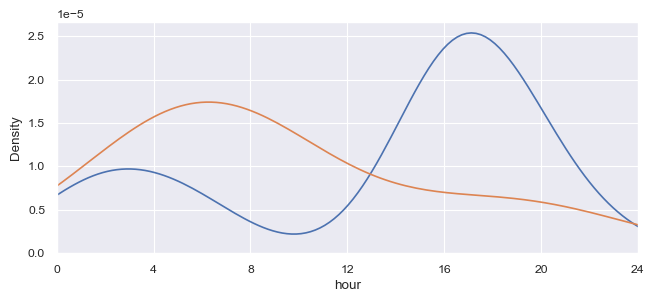

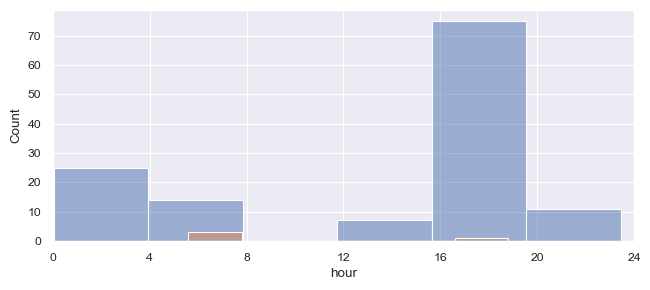

In [48]:
show_patterns(all_transfers_df, ['0x1a26db1b2baf0b23f18e19375e8fdc159feb707e','0x33321e44c2861033fb80ad04f93e4ccd25f2beef'], hour_bins=6, show_kde=True)

### To do: Find a way to cluster the addresses

In [159]:
# Number of nearest neighbours to consider
k = 5

# This will store the clusters. Each cluster is a set of nodes (i.e., a set of indices).
clusters = []

threshold = 0.5

# Iterate over all embeddings
for i in range(embeddings.shape[0]):
    # Query the index for the k nearest neighbors of the i-th embedding
    D, I = index.search(embeddings[i:i+1], k)

    # The indices of the nearest neighbors of the i-th node are in I[0]
    neighbours = set(I[0][D[0] < threshold])

    # Check if the node is already part of a cluster
    for cluster in clusters:
        if i in cluster:
            # If the node is part of a cluster, we extend this cluster by the new neighbours
            cluster.update(neighbours)
            break
    else:
        # If the node was not part of any cluster, we create a new cluster
        clusters.append(neighbours)


print(len(clusters))
clusters
# 26,740

36566


[{0},
 {1},
 {2},
 {3,
  14205,
  16421,
  18579,
  19558,
  20368,
  24394,
  25743,
  26605,
  26778,
  27452,
  37341,
  39353,
  42582,
  44816,
  45024,
  45050,
  45052,
  45103,
  45153,
  45162,
  45168,
  45208,
  45233,
  45251,
  45253},
 {4},
 {5,
  3760,
  14205,
  19416,
  20368,
  24078,
  25270,
  26778,
  27452,
  29400,
  30800,
  35292,
  35786,
  37341,
  39337,
  39353,
  39371,
  39390,
  43261,
  44253,
  44662,
  45024,
  45037,
  45050,
  45052,
  45061,
  45158,
  45162,
  45163,
  45177,
  45180,
  45188,
  45251,
  45256},
 {6},
 {7},
 {8},
 {9},
 {10},
 {11},
 {12},
 {13},
 {14},
 {15},
 {16},
 {17},
 {18},
 {19},
 {20},
 {21},
 {22},
 {23},
 {24},
 {25},
 {26},
 {27},
 {28},
 {29},
 {30},
 {31},
 {32},
 {33},
 {34},
 {35},
 {36},
 {37},
 {38},
 {39},
 {40},
 {41, 20503, 25432, 32626, 39672, 47060, 47587},
 {42},
 {43},
 {44},
 {45},
 {46},
 {47},
 {48},
 {49},
 {50},
 {51},
 {52},
 {53},
 {54},
 {55},
 {56},
 {57,
  19476,
  21768,
  26165,
  30344,
  3776

## Old code

In [ ]:
## Create network graph
G = nx.from_pandas_edgelist(all_transfers_df, 'from', 'to', create_using=nx.Graph())

# Get the largest connected component (assuming graph is undirected)
largest_cc = max(nx.connected_components(G), key=len)
print(len(largest_cc))

# Create a subgraph of G consisting only of the nodes in the largest connected component
G_cc = G.subgraph(largest_cc)

# Creating a mapping of old node IDs to new node IDs
node_mapping = {node: i for i, node in enumerate(G_cc.nodes)}

# Relabeling the nodes in the graph according to the mapping
G_cc = nx.relabel_nodes(G_cc, node_mapping)

# Initialize Diff2Vec model
model = Diff2Vec(diffusion_number=10, diffusion_cover=40, dimensions=128, window_size=5, learning_rate=0.025) #same as in tutela
model.fit(G_cc)

# Get embeddings
embeddings = model.get_embedding()


## Manual check of Address Pair
#idx1 = node_mapping['0x85e5472752a6f00775faca4d5179bde1081571b0']
#idx2 = node_mapping['0xbf886e3069d0dfd64e384c93da322f775faa8876']
#print(idx1,idx2)

In [ ]:
df1 = pd.read_csv('../only_transfers.csv')
df2 = pd.read_csv('../transfersPlusNative.csv')
df3 = pd.read_csv('../other_parameters.csv')

print('Dataset: only Transfers / transfers and native / other params')
print(f'Mean Rank: {df1["Rank"].mean()} / {df2["Rank"].mean()} / {df3["Rank"].mean()}')
print(f'Median Rank: {df1["Rank"].median()} / {df2["Rank"].median()} / {df3["Rank"].median()}')
print(f'Mean Distance: {df1["Distance"].mean()} / {df2["Distance"].median()} / {df3["Distance"].mean()}')
print(f'Median Distance: {df1["Distance"].median()} / {df2["Distance"].median()} / {df3["Distance"].median()}')

In [29]:
# Assuming `embeddings` is a 2D numpy array where each row is the embedding of a node
# Normalize embeddings
embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)

# Build the index
index = faiss.IndexFlatL2(embeddings.shape[1])

# Add vectors to the index
index.add(embeddings)

idx = node_map['0x85e5472752a6f00775faca4d5179bde1081571b0']
# Query the index for the nearest neighbors of any embedding
D, I = index.search(embeddings[idx:idx+1], embeddings.shape[0])

# D and I are the distances and indices of the nearest neighbors, respectively
print(D)  # Distance to nearest neighbors
print(I)  # Indices of nearest neighbors

[[0.        0.5247102 0.5557841 ... 2.5168133 2.5366912 2.5879552]]
[[34899 34898 34902 ...  9402  8722 17449]]
